In [67]:
import pandas as pd
from scaling import standardize, normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


In [55]:

#df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
#df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
#df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

attack_files = [df2016, df2017, df2018, df2020]
#all_files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

df = pd.concat(attack_files, axis=0, ignore_index=True)

df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name', 'longitude', 'latitude', 'date_time', 'distance',  'temperature', 'sin_time', 'cos_time'])
df = standardize(df, ['velocity']) # standarize the data
df = normalize(df, ['velocity'], 0, 1) # normalize the data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('attack', axis=1), df['attack'], test_size=0.2, random_state=42)


In [56]:

# Create a random forest classifier model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', round(accuracy*100, 2), "%")

Accuracy: 87.94 %


In [62]:
y_pred_count = Counter(y_pred)
y_test_count = y_test.value_counts()

print('y_test (faktisk):\n', y_test_count)
print('y_pred (predikert):', y_pred_count)


y_test (hva som faktisk har blitt satt):
 0    21959
1     2136
Name: attack, dtype: int64
y_pred (hva som er predikert og satt deretter): Counter({0: 22593, 1: 1502})


              precision    recall  f1-score   support

           0       0.92      0.95      0.93     21959
           1       0.24      0.17      0.20      2136

    accuracy                           0.88     24095
   macro avg       0.58      0.56      0.57     24095
weighted avg       0.86      0.88      0.87     24095



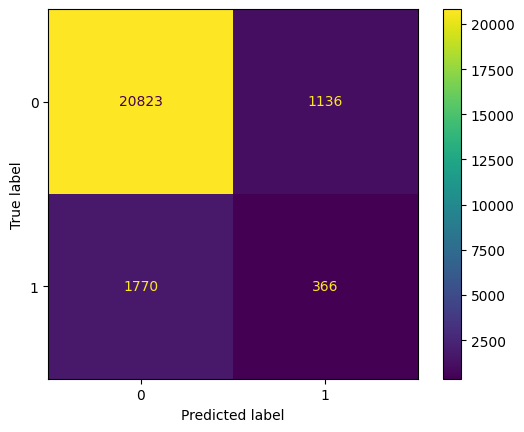

In [68]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)

disp.plot()
plt.show()

#True Negative (Top-Left Quadrant)
#False Positive (Top-Right Quadrant)
#False Negative (Bottom-Left Quadrant)
#True Positive (Bottom-Right Quadrant)

# All numeric features

In [94]:
df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

#attack_files = [df2016, df2017, df2018, df2020]
all_files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

df = pd.concat(all_files, axis=0, ignore_index=True)

df['date_time'] = pd.to_datetime(df['date_time'])

df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name',  'distance', 'sin_time', 'cos_time', 'date_time',])
df = standardize(df, ['velocity', 'longitude', 'latitude', 'temperature', 'altitude']) # standarize the data
df = normalize(df, ['velocity', 'longitude', 'latitude', 'temperature', 'altitude'], 0, 1) # normalize the data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('attack', axis=1), df['attack'], test_size=0.2, random_state=42)

In [91]:
# Create a random forest classifier model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', round(accuracy*100, 2), "%")

Accuracy: 99.36 %


In [92]:
y_pred_count = Counter(y_pred)
y_test_count = y_test.value_counts()

print('y_test (faktisk):\n', y_test_count)
print('y_pred (predikert):', y_pred_count)

y_test (faktisk):
 0    45744
1     2156
Name: attack, dtype: int64
y_pred (predikert): Counter({0: 45973, 1: 1927})


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     45744
           1       0.98      0.88      0.92      2156

    accuracy                           0.99     47900
   macro avg       0.99      0.94      0.96     47900
weighted avg       0.99      0.99      0.99     47900



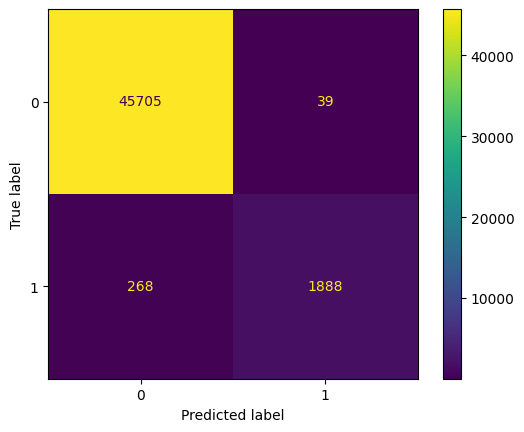

In [93]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)

disp.plot()
plt.show()

In [106]:
print(X_train)


        altitude  temperature  date_time  latitude  longitude      velocity
111909  0.139655     0.918367   0.491760  0.654424   0.409731  2.827974e-07
155056  0.588966     0.344023   0.811912  0.822375   0.651899  3.181471e-06
68508   0.089991     0.521866   0.353244  0.724496   0.417557  7.069936e-08
127662  0.294600     0.282799   0.669171  0.793436   0.331643  1.322078e-05
107134  0.248911     0.084548   0.480608  0.542689   0.372496  7.069936e-08
...          ...          ...        ...       ...        ...           ...
119879  0.251806     0.472303   0.653926  0.539333   0.371526  1.081700e-05
103694  0.160540     0.259475   0.484106  0.657786   0.403952  2.120981e-07
131932  0.133557     0.577259   0.656975  0.655282   0.410977  7.069936e-08
146867  0.647924     0.536443   0.655593  0.835364   0.634539  3.393569e-06
121958  0.134479     0.661808   0.654945  0.656227   0.412053  1.343288e-06

[191600 rows x 6 columns]


[0.0836965  0.02208696 0.68393459 0.10645298 0.09807653 0.00575244]


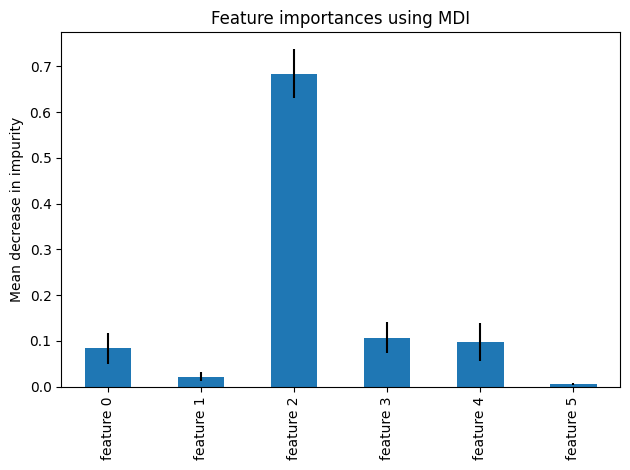

In [107]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

print(importances)

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# PCA

In [95]:
df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

#attack_files = [df2016, df2017, df2018, df2020]
all_files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

df = pd.concat(all_files, axis=0, ignore_index=True)

df['date_time'] = pd.to_datetime(df['date_time'])

df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name',  'distance', 'sin_time', 'cos_time'])
df = standardize(df, ['velocity', 'longitude', 'latitude', 'date_time', 'temperature', 'altitude']) # standarize the data

In [97]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# create a PCA object
pca = PCA()

# fit the data to the model
pca.fit(scaled_data)

# print the covariance matrix
cov_matrix = np.cov(scaled_data.T)
print("Covariance Matrix:\n", cov_matrix)

# display the explained variance ratio
print("Explained Variance Ratio:\n", pca.explained_variance_ratio_)

# display the principal components
print("Principal Components:\n", pca.components_)

Covariance Matrix:
 [[ 1.00000418  0.12049183  0.59702452  0.42820436  0.50618551  0.0645676
  -0.12865735]
 [ 0.12049183  1.00000418  0.11439435 -0.00841061  0.03056113  0.01749897
  -0.0084504 ]
 [ 0.59702452  0.11439435  1.00000418  0.3376258   0.42165015  0.01844789
  -0.18426953]
 [ 0.42820436 -0.00841061  0.3376258   1.00000418  0.85208372  0.06655804
  -0.10085531]
 [ 0.50618551  0.03056113  0.42165015  0.85208372  1.00000418  0.07670874
  -0.0766781 ]
 [ 0.0645676   0.01749897  0.01844789  0.06655804  0.07670874  1.00000418
  -0.01345129]
 [-0.12865735 -0.0084504  -0.18426953 -0.10085531 -0.0766781  -0.01345129
   1.00000418]]
Explained Variance Ratio:
 [0.37666779 0.15444567 0.14323918 0.13959747 0.11025028 0.05576643
 0.02003318]
Principal Components:
 [[ 0.47892127  0.07494135  0.43995392  0.50704688  0.53696788  0.07162853
  -0.14455818]
 [-0.20309256 -0.69447381 -0.32043361  0.35568811  0.29212024  0.12005105
   0.38408505]
 [ 0.00955843  0.4220793  -0.09796468 -0.00573604